<a href="https://colab.research.google.com/github/usmanqadeer1/AI-MLProjects/blob/master/Tensorflow_Specialization/Time_series_temp_sunspots_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.3.0


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [ ]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv

--2020-09-20 17:53:49--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  66.33K  --.-KB/s    in 0.02s   

2020-09-20 17:53:49 (2.80 MB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [67921/67921]



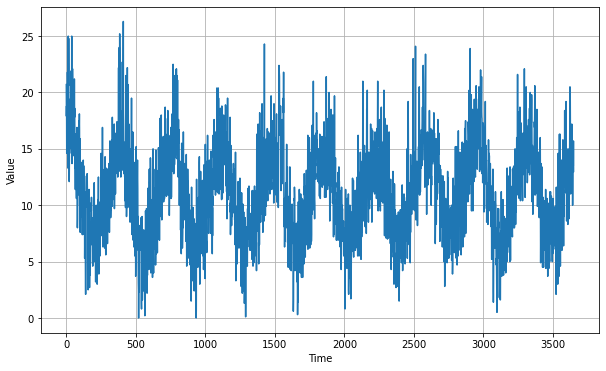

In [ ]:
import csv
time_step = []
temps = []

with open('/tmp/daily-min-temperatures.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    i = 0
    for row in reader:
      temps.append(float(row[1]))
      time_step.append(i)
      i += 1

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [ ]:
split_time = 2500
time_train = time_step[:split_time]
x_train = series[:split_time]
time_valid = time_step[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, -1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    # taking window_size + 1 to get next value to window_size as label
    ds = ds.window(size = window_size+1, shift = 1, drop_remainder = True)
    ds = ds.flat_map(lambda w:w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    ds = ds.batch(batch_size).prefetch(1)

    return ds

In [ ]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(size = window_size, shift = 1, drop_remainder = True)
    ds = ds.flat_map(lambda w:w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

## LEARNING RATE CHECK

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters = 50, kernel_size = 5, input_shape = [None, 1], activation = 'relu'),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(60, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(60, return_sequences=True)),
  tf.keras.layers.Dense(30, activation = 'relu'),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x*100) 
])

# lr_schedule = tf.keras.callbacks.LearningRateScheduler(
#     lambda epoch: 1e-8 * 10**(epoch / 20))
# optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.Adam(lr=1e-3)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)
Epoch 1/100
10/10 [==============================] - 0s 27ms/step - loss: 11.1690 - mae: 11.6619
Epoch 2/100
10/10 [==============================] - 0s 30ms/step - loss: 5.0786 - mae: 5.5603
Epoch 3/100
10/10 [==============================] - 0s 28ms/step - loss: 3.4501 - mae: 3.9224
Epoch 4/100
10/10 [==============================] - 0s 28ms/step - loss: 2.8310 - mae: 3.2978
Epoch 5/100
10/10 [==============================] - 0s 27ms/step - loss: 2.5280 - mae: 2.9917
Epoch 6/100
10/10 [==============================] - 0s 26ms/step - loss: 2.3753 - mae: 2.8374
Epoch 7/100
10/10 [==============================] - 0s 27ms/step - loss: 2.2841 - mae: 2.7433
Epoch 8/100
10/10 [==============================] - 0s 28ms/step - loss: 2.2399 - mae: 2.6990
Epoch 9/100
10/10 [==============================] - 0s 28ms/step - loss: 2.2442 - mae: 2.7030
Epoch 10/100
10/10 [=====================

0.1

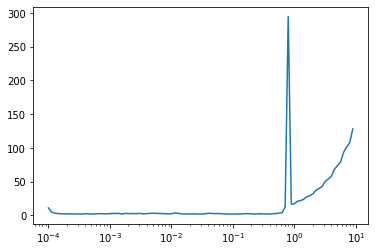

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
# plt.axis([1e-8, 1e-4, 0, 60])
history.history["lr"][np.argmin(history.history["loss"])]

## Training

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters = 60, kernel_size = 5, input_shape = [None, 1], activation = 'relu'),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(60, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(60, return_sequences=True)),
  tf.keras.layers.Dense(30, activation = 'relu'),
  tf.keras.layers.Dense(10, activation = 'relu'),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x*100) 
])


model.summary()
                                    

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 60)          360       
_________________________________________________________________
bidirectional (Bidirectional (None, None, 120)         58080     
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 120)         86880     
_________________________________________________________________
dense (Dense)                (None, None, 30)          3630      
_________________________________________________________________
dense_1 (Dense)              (None, None, 10)          310       
_________________________________________________________________
dense_2 (Dense)              (None, None, 1)           11        
_________________________________________________________________
lambda (Lambda)              (None, None, 1)           0

In [ ]:
optimizer = tf.keras.optimizers.Adam(0.001)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150)

Epoch 1/150
25/25 [==============================] - 0s 20ms/step - loss: 3.7435 - mae: 4.2111
Epoch 2/150
25/25 [==============================] - 0s 18ms/step - loss: 2.1584 - mae: 2.6166
Epoch 3/150
25/25 [==============================] - 0s 17ms/step - loss: 2.2075 - mae: 2.6666
Epoch 4/150
25/25 [==============================] - 1s 20ms/step - loss: 2.0488 - mae: 2.5042
Epoch 5/150
25/25 [==============================] - 0s 20ms/step - loss: 1.9995 - mae: 2.4537
Epoch 6/150
25/25 [==============================] - 0s 17ms/step - loss: 1.9008 - mae: 2.3543
Epoch 7/150
25/25 [==============================] - 0s 17ms/step - loss: 1.8577 - mae: 2.3115
Epoch 8/150
25/25 [==============================] - 0s 17ms/step - loss: 1.8483 - mae: 2.3001
Epoch 9/150
25/25 [==============================] - 0s 20ms/step - loss: 1.8754 - mae: 2.3297
Epoch 10/150
25/25 [==============================] - 1s 20ms/step - loss: 1.8114 - mae: 2.2624
Epoch 11/150
25/25 [=============================

In [ ]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

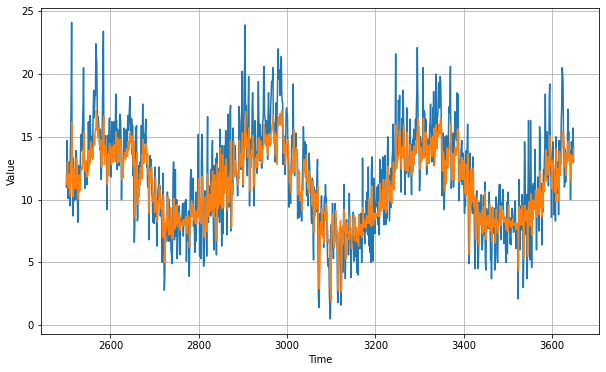

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

# PLOT SHOULD SHOW PROJECTIONS FOLLOWING ORIGINAL DATA CLOSELY

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()


1.8483243

In [ ]:
print(rnn_forecast)


[11.362952 11.225788 12.341783 ... 13.008274 13.169636 14.113095]
